# Hybrid Model to detect Parkinsonism disease

 ## Get the current status and usage of NVIDIA GPU(s)

In [1]:
!nvidia-smi

Wed Dec 27 13:51:46 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              23W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip install pyyaml h5py  # Required to save models in HDF5 format
!pip install comet_ml tensorflow numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.8/586.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 514.7/514.7 kB 34.2 MB/s eta 0:00:00
  Attempting uninstall: websocket-client
    Found existing installation: websocket-client 1.7.0
    Uninstalling websocket-client-1.7.0:
      Successfully uninstalled websocket-client-1.7.0
  Attempting uninstall: python-box
    Found existing installation: python-box 7.1.1
    Uninstalling python-box-7.1.1:
      Successfully uninstalled python-box-7.1.1


##Imports

In [3]:
import comet_ml
import os
import numpy as np
import cv2
import PIL
import random
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.applications.inception_v3 import InceptionV3
from keras.applications import MobileNetV2
from keras.layers import Input, Flatten, Dense, Dropout, concatenate, LeakyReLU
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import Sequence
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from keras.models import load_model
from keras.models import model_from_json
from google.colab import userdata
from tensorflow.keras import regularizers

from keras.callbacks import EarlyStopping
from keras import backend as K
from google.colab import drive
from dataclasses import dataclass

In [4]:
# Ensure deterministic behavior on GPU (if available)
if len(tf.config.list_physical_devices('GPU')) > 0:
    print('GPU name: ', tf.config.list_physical_devices('GPU')[0].name)
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


GPU name:  /physical_device:GPU:0
Num GPUs Available:  1


###Connect to the Google Drive

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


###Define parameters

In [6]:
@dataclass(frozen=True)
class DatasetConfiguration:
  IMG_HEIGHT = 224
  IMG_WIDTH = 224
  CHANNELS = 3
  DATASET_PATH = '/content/drive/MyDrive/handpd_dataset' # Define the path to the dataset folder
  RANDOM_STATE = 42

@dataclass(frozen=True)
class TrainingConfiguration:
  BATCH_SIZE = 20
  EPOCHS = 35
  DROPOUT= 0.3
  INCEPTIONV3_UNFREEZING_LAYERS = 20
  MOBILENETV2_UNFREEZING_LAYERS = 10
  FIRST_INPUT_UNIT = 256
  OUTPUT_UNIT = 2
  INPUT_ACTIVATION = 'tanh'
  OUTPUT_ACTIVATION = 'sigmoid'
  FINE_TUNE_LR = 0.001

@dataclass(frozen=True)
class CometMLConfiguration:
  API_KEY = userdata.get('CometMLAPIKey')
  PROJECT_NAME = "artographia-v1"
  WORKSPACE = "vinurirodrigo"

@dataclass(frozen=True)
class AugmentationConfiguration:
  ROTATION_RANGE = 20
  WIDTH_SHIFT_RANGE = 0.2
  HEIGHT_SHIFT_RANGE = 0.2
  SHEAR_RANGE = 0.2
  ZOOM_RANGE = 0.2
  FILL_MODE = 'nearest'
  #check seed, regularization, saprcityconstrain

In [7]:
# Set a random seed for reproducibility
np.random.seed(DatasetConfiguration.RANDOM_STATE)
random.seed(DatasetConfiguration.RANDOM_STATE)
tf.random.set_seed(DatasetConfiguration.RANDOM_STATE)

In [8]:
# Create an experiment with the api key
experiment = comet_ml.Experiment(
    api_key = CometMLConfiguration.API_KEY,
    project_name= CometMLConfiguration.PROJECT_NAME,
    workspace= CometMLConfiguration.WORKSPACE,
    auto_param_logging=True,
    auto_metric_logging=True,
    auto_histogram_weight_logging=True,
    auto_histogram_gradient_logging=True,
    auto_histogram_activation_logging=True,
    auto_histogram_epoch_rate=True,
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/vinurirodrigo/artographia-v1/048cc77fdd3c4da29b1914c1025ad01f



##Loading the Dataset and Preprocessing

In [9]:
parameters = {
    "batch_size": TrainingConfiguration.BATCH_SIZE,
    "epochs": TrainingConfiguration.EPOCHS,
    "learning_rate":TrainingConfiguration.FINE_TUNE_LR,
    "GoogLeNet_unfreeze_layers": TrainingConfiguration.INCEPTIONV3_UNFREEZING_LAYERS,
    "MobileNetV2_unfreeze_layers": TrainingConfiguration.MOBILENETV2_UNFREEZING_LAYERS,
    "optimizer": "SGD", #SGD, // refer for more details: chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://www.researchgate.net/profile/Pedram-Khatamino/publication/334168335_A_Deep_Learning-CNN_Based_System_for_Medical_Diagnosis_An_Application_on_Parkinson%27s_Disease_Handwriting_Drawings/links/5dffac1392851c836493b082/A-Deep-Learning-CNN-Based-System-for-Medical-Diagnosis-An-Application-on-Parkinsons-Disease-Handwriting-Drawings.pdf
    "loss": "binary_crossentropy",
    "validation_split": 0.1,
}

experiment.log_parameters(parameters)

In [10]:
# Define a function to load and preprocess images
data = []
labels = []
def load_and_preprocess_images(path, label):
  # Initialize empty lists to store data and labels
    for filename in sorted(os.listdir(path)):
        if filename.endswith('.jpg'):
            # Load the image
            img = cv2.imread(os.path.join(path, filename))
            experiment.log_image(os.path.join(path, filename), filename,overwrite=False, image_format="jpg")
            # Resize the image to a consistent size (e.g., 224x224)
            img = cv2.resize(img, (DatasetConfiguration.IMG_HEIGHT, DatasetConfiguration.IMG_WIDTH))
            # Normalize(min-max scaling) pixel values to be between 0 and 1
            img = img / 255.0
            # Append the image data and label to the lists
            data.append(img)
            labels.append(label)

In [11]:
# Load and preprocess images from the 'HealthySpiral' folder
load_and_preprocess_images(os.path.join(DatasetConfiguration.DATASET_PATH,'ResizeHealthySpiral'), label=0)

In [12]:
# Load and preprocess images from the 'PatientSpiral' folder
load_and_preprocess_images(os.path.join(DatasetConfiguration.DATASET_PATH, 'ResizePatientSpiral'), label=1)

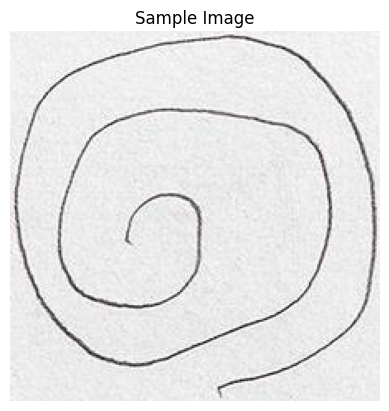

In [13]:
# Function to display an image from the dataset
def display_image(image):
    plt.imshow(image)
    plt.title("Sample Image")
    plt.axis('off')  # Hide axis values
    plt.show()

# Display an image from the PD class
image_index = 0
display_image(data[image_index])

In [14]:
# Convert lists to NumPy arrays
data = np.array(data)
labels = np.array(labels)

###Splitting the Dataset

In [15]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=DatasetConfiguration.RANDOM_STATE)
# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

###Concatenating Features from Base Models

In [16]:
# Define a single input layer
INPUT_LAYER = Input(shape=(DatasetConfiguration.IMG_HEIGHT, DatasetConfiguration.IMG_WIDTH, DatasetConfiguration.CHANNELS))

In [17]:
#Create the GoogLeNet base model
base_model_inception = InceptionV3(weights='imagenet', include_top=False, input_tensor= INPUT_LAYER)

#Create the MobileNetV2 base model
base_model_mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_tensor=INPUT_LAYER)

87910968/87910968 [==============================] - 3s 0us/step


9406464/9406464 [==============================] - 1s 0us/step


In [18]:
# Freeze the layers of the pre-trained models
for layer in base_model_inception.layers:
    layer.trainable = False
for layer in base_model_mobilenet.layers:
    layer.trainable = False

##Feature Extraction and Concatenation

In [19]:
# Remove the top classification layers from the base models
inception_features = Flatten()(base_model_inception.layers[-1].output)
mobilenet_features = Flatten()(base_model_mobilenet.layers[-1].output)

# Concatenate the output features from both models
merged_features = concatenate([inception_features, mobilenet_features])

## Fine Tuning

In [20]:
print("Number of GoogLeNet Layers ", len(base_model_inception.layers))
print("Number of MobileNetV2 Layers ",len(base_model_mobilenet.layers))
# Fine-tuning by unfreezing layers and training
for layer in base_model_inception.layers[-TrainingConfiguration.INCEPTIONV3_UNFREEZING_LAYERS:]:
    layer.trainable = True
for layer in base_model_mobilenet.layers[-TrainingConfiguration.MOBILENETV2_UNFREEZING_LAYERS:]:
    layer.trainable = True

Number of GoogLeNet Layers  311
Number of MobileNetV2 Layers  154


## Adding new Layers to the model

In [21]:
# Add a classification layer
predictions = Dense(TrainingConfiguration.FIRST_INPUT_UNIT, TrainingConfiguration.INPUT_ACTIVATION)(merged_features)
predictions = Dropout(TrainingConfiguration.DROPOUT)(predictions)
output = Dense(TrainingConfiguration.OUTPUT_UNIT, TrainingConfiguration.OUTPUT_ACTIVATION)(predictions)

In [22]:
# Create the custom hybrid model
hybrid_model = Model(inputs=INPUT_LAYER, outputs=output)

## Data Augmentation

In [23]:
# Data augmentation
datagen_inception = ImageDataGenerator(
    rotation_range = AugmentationConfiguration.ROTATION_RANGE,
    width_shift_range = AugmentationConfiguration.WIDTH_SHIFT_RANGE,
    height_shift_range = AugmentationConfiguration.WIDTH_SHIFT_RANGE,
    shear_range = AugmentationConfiguration.SHEAR_RANGE,
    zoom_range = AugmentationConfiguration.ZOOM_RANGE,
    horizontal_flip = True,
    fill_mode = AugmentationConfiguration.FILL_MODE,
    )
# Fit the data augmentation generator to the training data
datagen_inception.fit(X_train)  # Set the seed for reproducibility


## Compile the hybrid model

In [24]:
hybrid_model.compile(optimizer=SGD(learning_rate=TrainingConfiguration.FINE_TUNE_LR),
    loss='binary_crossentropy',
    metrics=['accuracy'])

hybrid_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0][0

## Train the hybrid model

In [25]:
history = hybrid_model.fit(datagen_inception.flow(X_train, y_train, batch_size=TrainingConfiguration.BATCH_SIZE),
                           steps_per_epoch=len(X_train) / TrainingConfiguration.BATCH_SIZE,
                           epochs=TrainingConfiguration.EPOCHS,
                           validation_data=(X_test, y_test))

COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE
COMET WARNING: auto_histogram_gradient_logging is True, but inputs and targets are not available; unable to log gradients
COMET WARNING: auto_histogram_activation_logging is True, but inputs are not available; unable to log activations


Epoch 1/35
49/49 [==============================] - 36s 473ms/step - loss: 0.5842 - accuracy: 0.7307 - val_loss: 0.5437 - val_accuracy: 0.7642
Epoch 2/35
49/49 [==============================] - 18s 358ms/step - loss: 0.4463 - accuracy: 0.8120 - val_loss: 0.5108 - val_accuracy: 0.7886
Epoch 3/35
49/49 [==============================] - 17s 356ms/step - loss: 0.4125 - accuracy: 0.8404 - val_loss: 0.4290 - val_accuracy: 0.8333
Epoch 4/35
49/49 [==============================] - 18s 361ms/step - loss: 0.4285 - accuracy: 0.8272 - val_loss: 0.4228 - val_accuracy: 0.8374
Epoch 5/35
49/49 [==============================] - 18s 359ms/step - loss: 0.3822 - accuracy: 0.8394 - val_loss: 0.4377 - val_accuracy: 0.8171
Epoch 6/35
49/49 [==============================] - 18s 361ms/step - loss: 0.3753 - accuracy: 0.8435 - val_loss: 0.4213 - val_accuracy: 0.8211
Epoch 7/35
49/49 [==============================] - 18s 358ms/step - loss: 0.3651 - accuracy: 0.8648 - val_loss: 0.4417 - val_accuracy: 0.8089

###Convert the model architecture to JSON and save it to the Comet ML

In [26]:
model_architecture_json = hybrid_model.to_json()

In [27]:
# Log the model architecture to Comet as text
experiment.log_text("Hybrid Model Architecture", model_architecture_json)

COMET WARNING: Passed step value '{"class_name": "Functional", "config": {"name": "model", "trainable": true, "layers": [{"module": "keras.layers", "class_name": "InputLayer", "config": {"batch_input_shape": [null, 224, 224, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_1"}, "registered_name": null, "name": "input_1", "inbound_nodes": []}, {"module": "keras.layers", "class_name": "Conv2D", "config": {"name": "conv2d", "trainable": false, "dtype": "float32", "filters": 32, "kernel_size": [3, 3], "strides": [2, 2], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "linear", "use_bias": false, "kernel_initializer": {"module": "keras.initializers", "class_name": "GlorotUniform", "config": {"seed": null}, "registered_name": null}, "bias_initializer": {"module": "keras.initializers", "class_name": "Zeros", "config": {}, "registered_name": null}, "kernel_regularizer": null, "bias_regularizer": null, "activity_reg

{'web': 'https://www.comet.com/api/asset/download?assetId=d33aad4d129b42758afe5586f2c4c8e2&experimentKey=048cc77fdd3c4da29b1914c1025ad01f',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=d33aad4d129b42758afe5586f2c4c8e2&experimentKey=048cc77fdd3c4da29b1914c1025ad01f',
 'assetId': 'd33aad4d129b42758afe5586f2c4c8e2'}

### Evaluate the model

In [28]:
# Evaluate the model (minor adjustments to evaluation metrics)
evaluation_metrics = hybrid_model.evaluate(X_test, y_test, verbose=0)
evaluation_loss = evaluation_metrics[0]
accuracy = evaluation_metrics[1]  # Use accuracy from evaluation

#### Plot the confusion matrix

8/8 [==============================] - 3s 38ms/step


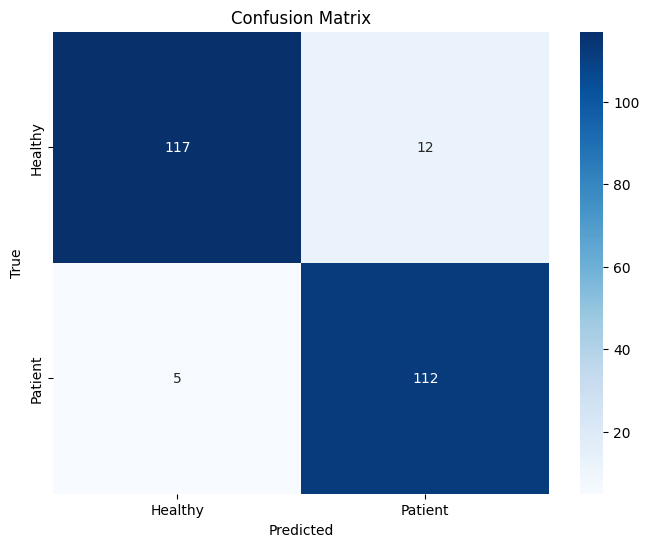

In [29]:
# Make predictions on the test dataset
y_pred = hybrid_model.predict(X_test)

# Convert one-hot encoded predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Calculate the confusion matrix
confusion_mtx = confusion_matrix(y_true_labels, y_pred_labels)

# Log the confusion matrix to Comet
experiment.log_confusion_matrix(matrix=confusion_mtx)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Healthy', 'Patient'], yticklabels=['Healthy', 'Patient'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [30]:
# Calculate metrics (accuracy, precision, recall, f1_score) from the confusion matrix
total_samples = np.sum(confusion_mtx)
accuracy = np.sum(np.diag(confusion_mtx)) / total_samples
precision = confusion_mtx[1, 1] / (confusion_mtx[1, 1] + confusion_mtx[0, 1])
recall = confusion_mtx[1, 1] / (confusion_mtx[1, 1] + confusion_mtx[1, 0])
f1_score = 2 * (precision * recall) / (precision + recall)
evaluation_metrics = hybrid_model.evaluate(X_test, y_test, verbose=0)
evaluation_loss = evaluation_metrics[0]

# Print the evaluation results
print("loss_mtx", evaluation_loss)
print("accuracy_mtx", accuracy)
print("f1_score_mtx", f1_score)
print("precision_mtx", precision)
print("recall_mtx", recall)

loss_mtx 0.21788933873176575
accuracy_mtx 0.9308943089430894
f1_score_mtx 0.9294605809128631
precision_mtx 0.9032258064516129
recall_mtx 0.9572649572649573


In [31]:
# Generate a classification report
classification_rep = classification_report(y_true_labels, y_pred_labels, target_names=['Healthy', 'Patient'],
                                           output_dict=True)

# Extract metrics from classification report
precision_healthy = classification_rep['Healthy']['precision']
recall_healthy = classification_rep['Healthy']['recall']
f1_healthy = classification_rep['Healthy']['f1-score']

precision_patient = classification_rep['Patient']['precision']
recall_patient = classification_rep['Patient']['recall']
f1_patient = classification_rep['Patient']['f1-score']

# Log the extracted metrics to Comet
experiment.log_metric("precision_healthy", precision_healthy)
experiment.log_metric("recall_healthy", recall_healthy)
experiment.log_metric("f1_healthy", f1_healthy)

experiment.log_metric("precision_patient", precision_patient)
experiment.log_metric("recall_patient", recall_patient)
experiment.log_metric("f1_patient", f1_patient)

print("Classification Report:\n", classification_rep)

Classification Report:
 {'Healthy': {'precision': 0.9590163934426229, 'recall': 0.9069767441860465, 'f1-score': 0.9322709163346613, 'support': 129}, 'Patient': {'precision': 0.9032258064516129, 'recall': 0.9572649572649573, 'f1-score': 0.9294605809128631, 'support': 117}, 'accuracy': 0.9308943089430894, 'macro avg': {'precision': 0.9311210999471179, 'recall': 0.9321208507255019, 'f1-score': 0.9308657486237621, 'support': 246}, 'weighted avg': {'precision': 0.9324818459712889, 'recall': 0.9308943089430894, 'f1-score': 0.9309342933901474, 'support': 246}}


##Save the Model Architecture to the Comet ML

In [32]:
hybrid_model.save('parkinsons_detection_model.keras')

In [33]:
# Save the trained model to Comet
experiment.log_model(
    name= "parkinsons_detection_model",
    file_or_folder="parkinsons_detection_model.keras",
    overwrite=False  # Set to True to overwrite any existing model with the same name
)

{'web': 'https://www.comet.com/api/asset/download?assetId=9868f0bdb827418dbce4128a592e3549&experimentKey=048cc77fdd3c4da29b1914c1025ad01f',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=9868f0bdb827418dbce4128a592e3549&experimentKey=048cc77fdd3c4da29b1914c1025ad01f',
 'assetId': '9868f0bdb827418dbce4128a592e3549'}

In [34]:
# Load your existing trained model
hybrid_model = tf.keras.models.load_model('parkinsons_detection_model.keras')

# Define a function to convert the model to a lightweight format (e.g., TensorFlow Lite)
def convert_to_lite_model(original_model):
    converter = tf.lite.TFLiteConverter.from_keras_model(original_model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_model = converter.convert()
    return tflite_model

# Convert the model to a lightweight format
lite_model = convert_to_lite_model(hybrid_model)
tf.lite.experimental.Analyzer.analyze(model_content=lite_model)

# Save the lightweight model to a file
lite_model_filename = 'parkinsons_detection_model_lite.tflite'
with open(lite_model_filename, 'wb') as f:
    f.write(lite_model)

# Log the lightweight model to Comet ML with a custom filename
experiment.log_asset(file_data=lite_model_filename, file_name='lite_model.tflite')

=== TFLite ModelAnalyzer ===

Your TFLite model has '1' subgraph(s). In the subgraph description below,
T# represents the Tensor numbers. For example, in Subgraph#0, the CONV_2D op takes
tensor #0 and tensor #9 and tensor #25 as input and produces tensor #300 as output.

Subgraph#0 main(T#0) -> [T#494]
  Op#0 CONV_2D(T#0, T#9, T#25) -> [T#300]
  Op#1 CONV_2D(T#0, T#8, T#26) -> [T#301]
  Op#2 CONV_2D(T#301, T#173, T#27) -> [T#302]
  Op#3 CONV_2D(T#302, T#174, T#28) -> [T#303]
  Op#4 MAX_POOL_2D(T#303) -> [T#304]
  Op#5 CONV_2D(T#304, T#175, T#29) -> [T#305]
  Op#6 CONV_2D(T#305, T#176, T#30) -> [T#306]
  Op#7 MAX_POOL_2D(T#306) -> [T#307]
  Op#8 AVERAGE_POOL_2D(T#307) -> [T#308]
  Op#9 CONV_2D(T#308, T#177, T#31) -> [T#309]
  Op#10 CONV_2D(T#307, T#178, T#32) -> [T#310]
  Op#11 CONV_2D(T#307, T#179, T#33) -> [T#311]
  Op#12 CONV_2D(T#311, T#180, T#34) -> [T#312]
  Op#13 CONV_2D(T#307, T#181, T#35) -> [T#313]
  Op#14 CONV_2D(T#313, T#182, T#36) -> [T#314]
  Op#15 CONV_2D(T#314, T#183, T#

{'web': 'https://www.comet.com/api/asset/download?assetId=3de463292dba4fa4860619f9dc560204&experimentKey=048cc77fdd3c4da29b1914c1025ad01f',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=3de463292dba4fa4860619f9dc560204&experimentKey=048cc77fdd3c4da29b1914c1025ad01f',
 'assetId': '3de463292dba4fa4860619f9dc560204'}

## End the Comet ML experiment

In [35]:
experiment.end()

COMET WARNING: Couldn't retrieve Google Colab notebook content
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/vinurirodrigo/artographia-v1/048cc77fdd3c4da29b1914c1025ad01f
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [35]                : (0.7306910753250122, 0.9237805008888245)
COMET INFO:     batch_accuracy [175]         : (0.6470588445663452, 1.0)
COMET INFO:     batch_loss [175]             : (0.08266837894916534, 0.8135091066360474)
COMET INFO:     epoch_duration [35]          : (10.097753988000022, 36.646633302000055)
COMET INFO:     f1_healthy                   : 0.9322709163346613
COMET INFO:     f1_patient                   : 0.9294605809128631